# Ethics, Fairness and Explanation in AI Coursework

Your goal in this coursework is to implement and experiment with various explainability approaches in order to better understand the behaviour of a neural model applied to the Titanic dataset. As you will have a chance to observe, the dataset reflects some of the past social conventions and biases, which also affect the trained model. Explanations can serve as very useful tools for identifying such potential issues and gaining insight into the internal reasoning of machine learning systems.

## Data Loading and Preprocessing

We start by defining some helpful utility functions for data preprocessing. You will probably not need to change this code.

In [2]:
import numpy as np
import pandas as pd
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.utils import resample


class InvertibleColumnTransformer(ColumnTransformer):
    """
    This is an invertible version of a ColumnTransformer from sklearn.
    This allows us to recover the original feature values from their normalised
    versions in order to better understand the produced explanations.
    """
    def inverse_transform(self, X):
        if X.ndim == 1:
            X = np.expand_dims(X, axis=0)
        if X.shape[1] != len(self.get_feature_names_out()):
            raise ValueError(
                "X and the fitted transformer have different numbers of columns"
            )

        inverted_X_base = np.zeros((X.shape[0], self.n_features_in_))
        columns = [c for cs in self._columns for c in cs]
        inverted_X = pd.DataFrame(data=inverted_X_base, columns=columns)
        inverted_X = inverted_X.astype('object')
        for name, indices in self.output_indices_.items():
            transformer = self.named_transformers_.get(name, None)
            if transformer is None:
                continue

            selected_X = X[:, indices.start : indices.stop]
            if isinstance(transformer, OneHotEncoder):
                # Assumed only one column changing encoder at the end
                categories = transformer.inverse_transform(selected_X)
                inverted_X.loc[
                    :, columns[indices.start : indices.start + len(categories[0])]
                ] = categories
            else:
                # Assumed scaler-type transformer
                inverted_X.loc[
                    :, [columns[i] for i in range(indices.start, indices.stop)]
                ] = transformer.inverse_transform(selected_X)

        return inverted_X


def preprocess_train_data(
    df,
    scaled_features=None,
    categorical_features=None,
    scaler=RobustScaler(quantile_range=(10, 90)),
    categorical_encoder=OneHotEncoder(handle_unknown="ignore"),
):
    """
    Scales the continuous features using a RobustScaler and one-hot encodes
    the categorical features.
    """
    if scaled_features is None and categorical_features is None:
        warnings.warn("No features specified for preprocessing, using raw data.")
        scaled_features = []
        categorical_features = []
    elif scaled_features is None:
        scaled_features = [c for c in df.columns if c not in categorical_features]
    elif categorical_features is None:
        categorical_features = [c for c in df.columns if c not in scaled_features]

    preprocessor = InvertibleColumnTransformer(
        transformers=[
            ("num", scaler, scaled_features),
            ("cat", categorical_encoder, categorical_features),
        ],
        remainder="passthrough",
    )

    preprocessed_df = preprocessor.fit_transform(df)
    return preprocessed_df, preprocessor


def preprocess_test_data(df, preprocessor):
    preprocessed_df = preprocessor.transform(df)
    return preprocessed_df

/var/folders/t8/3700xn414yq959834wdg9n480000gn/T/ipykernel_76692/4197921857.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Here, we define a class for the Titanic dataset, which we will be using throughout the coursework.

In [3]:
import os
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


class TitanicDataset(Dataset):
    """
    Loads and preprocesses the Titanic dataset.
    """
    __create_key = object()

    @classmethod
    def create_datasets(
        cls,
        label_name="survived",
        split_seed=42,
        test_size=0.2,
    ):
        train_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=True,
        )
        test_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=False,
        )
        return train_dataset, test_dataset

    def __init__(
        self,
        create_key=None,
        label_name="Survived",
        split_seed=42,
        test_size=0.2,
        train=True,
    ):
        # Ensure that the dataset is being constructed properly
        if create_key != TitanicDataset.__create_key:
            raise ValueError(
                "Illegal initialisation attempt — please use create_datasets to initialise."
            )

        try:
            data_df = pd.read_csv("titanic-dataset.csv")
        except FileNotFoundError:
            raise FileNotFoundError("Titanic data file not found.")

        # Split the dataset into train and test
        x = data_df.drop(columns=[label_name, "name", "ticket", "cabin", "embarked", "boat", "body", "home.dest"])
        # For the purposes of this coursework, we just impute the missing age and fare with a median value
        x[['age']] = x[['age']].fillna(x[['age']].median())
        x[['fare']] = x[['fare']].fillna(x[['fare']].median())
        y = data_df[label_name]
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=split_seed, shuffle=True
        )
        if train:
            self.raw_data = x_train, y_train
        else:
            self.raw_data = x_test, y_test

        # Preprocess the data
        x_train_processed, preprocessor = preprocess_train_data(
            x_train, categorical_features=["sex"]
        )
        x_train = pd.DataFrame(
            x_train_processed, columns=preprocessor.get_feature_names_out()
        )
        x_test_processed = preprocess_test_data(x_test, preprocessor)
        x_test = pd.DataFrame(
            x_test_processed, columns=preprocessor.get_feature_names_out()
        )

        # Select data partition and convert to tensors
        if train:
            samples = x_train
            labels = y_train
        else:
            samples = x_test
            labels = y_test
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.long)
        self.features = preprocessor.get_feature_names_out()
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]
    
    def max(self):
        return self.samples.max(dim=0).values
    
    def min(self):
        return self.samples.min(dim=0).values

Finally, we call the code above to load and preprocess the data.

In [4]:
titanic_train_dataset, titanic_test_dataset = TitanicDataset.create_datasets(
    test_size=0.2,
    split_seed=42,
)
train_dl = DataLoader(
    dataset=titanic_train_dataset,
    batch_size=128,
    shuffle=False,
)
test_dl = DataLoader(
    dataset=titanic_test_dataset,
    batch_size=64,
    shuffle=False,
)

Note that the invertible transformer allows you to recover the original (unnormalised) feature values, as shown on the example below. You may find this helpful for understanding the produced explanations and commenting on them in your report.

In [5]:
titanic_test_dataset.preprocessor.inverse_transform(titanic_test_dataset.samples[0])

,pclass,age,sibsp,parch,fare,sex
0,3.0,35.0,0.0,0.0,7.125,male


## Exploratory Data Analysis

When faced with a new dataset, it is a good practice to perform an exploratory data analysis in order to understand the basic trends in the data. This will also allow you to put the explanations you obtain as part of this coursework into the relevant context. We will use the raw, unnormalised features for this purpose, as they are much more intuitive and human-understandable.

In [6]:
x_train, y_train = titanic_train_dataset.raw_data
x_train['survived'] = y_train
data_df = x_train

We start by displaying the feature values and labels for a few samples. The dataset contains data regarding the survival of some of the passengers involved in the [Titanic maritime disaster](https://en.wikipedia.org/wiki/Sinking_of_the_Titanic). The features contained in the data are as follows:
* `pclass`: Indicates the travelling class of the given passenger. Note that we treat this feature as numerical, as the different classes introduce a natural order.
* `sex`: Indicates the sex of the passenger.
* `age`: Provides the age of the passenger.
* `sibsp`: Denotes the total number of siblings and spouses of the given passenger also travelling on RMS Titanic.
* `parch`: Denotes the total number of parents or children of the given passenger also travelling on RMS Titanic.
* `fare`: Indicates the fare paid by the passenger for the journey.
* `survived`: The label indicating whether the patient survived the accident (1 = survived, 0 = did not survive).

There are other features included in the original dataset (such aspassenger name or point of embarkation), but we choose to ignore them for the purposes of this coursework.

In [7]:
data_df

,pclass,sex,age,sibsp,parch,fare,survived
772,3,male,17.0,0,0,7.8958,0
543,2,male,36.0,0,0,10.5000,0
289,1,female,18.0,0,2,79.6500,1
10,1,male,47.0,1,0,227.5250,0
147,1,male,28.0,0,0,42.4000,0
...,...,...,...,...,...,...,...
1095,3,female,28.0,0,0,7.6292,0
1130,3,female,18.0,0,0,7.7750,0
1294,3,male,28.5,0,0,16.1000,0
860,3,female,26.0,0,0,7.9250,1


Let us visualise the correlation between the individual columns of the data, computed using the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). Note that we excluded the `sex` feature from this visualisation, as it is categorical.

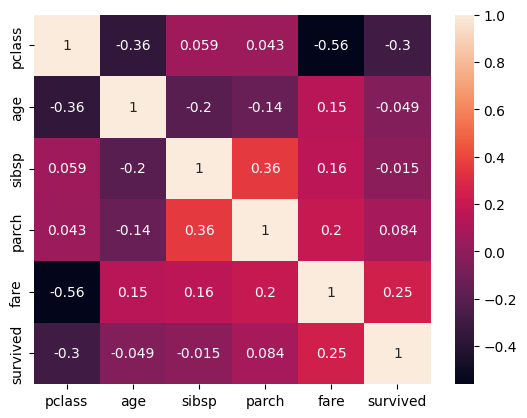

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = data_df.drop(columns=["sex"]).corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    fmt='.2g',
)
plt.show()

Since the previous plot does not include the categorical `sex` column, we also separately visualise its distribution, including the associated labels.

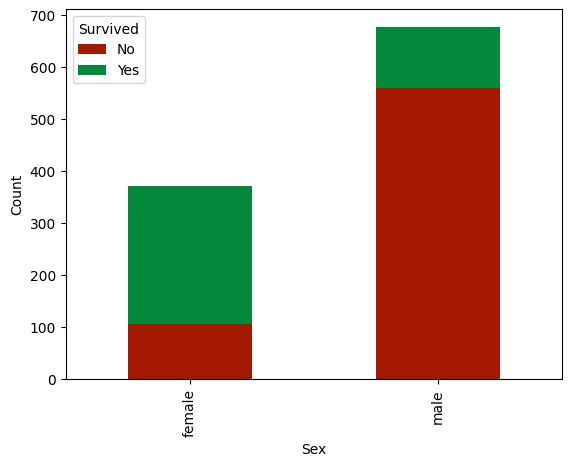

In [9]:
data_df.groupby(['sex', 'survived']).size().unstack().plot(
    kind='bar', stacked=True, color=['#a51900', '#02893b'], xlabel="Sex", ylabel="Count"
)
plt.legend(['No', 'Yes'], title="Survived")
plt.show()

**Task 1(a)**: <br />
**(i)** Considering the above visualisations, are there any trends or patterns that you can identify in the data? <br />

    There are a much higher proportion of the females present who survived relative to the men. Survival was also most highly correlated with the fare passengers paid, meaning the more expensive the ticket, the more likely they survived. The travelling class was also the feature most negatively correlated with survival. This initially seems a bit counterintuitive because of the reverse ordinality of the class system (i.e. first class, though a lower number = higher wealth/priveledge), however as the value of this class feature increases (to second / third class), the survival feature decreases. Additionally, there is a strong correlation between fare and class, supporting the observation that socio-economic status, reflected through the travel class and fare paid, significantly influenced survival outcomes.

**(ii)** Without having access to any particular model or the associated explanations, which features would you expect to be the most and least important for a neural network trained on the dataset? How can you tell and how certain can you be of your assessment? <br />

    The most impactful features are identified by considering factors such as feature distribution, correlation with the target variable, and domain relevance. As such it is likely that the features highlighted above - pclass, fare and sex - would all be most important. Evidently then the features less correlated with survival - age, sibsp, and parch - would be less relevant. I can be certain because features that show a strong correlation with the target variable are likely to be important.

    Understanding the historical context and domain specifics can also guide the importance of features. `Sex` is a historically significant factor because women and children were given priority in lifeboat allocation. `fare` and `pclass` also show substantial correlations (positive or negative) with survival, and they reflect socio-economic status, which could influence access to lifeboats.

**(iii)** Apart from inspecting the above plots, is there anything else you could do as part of the exploratory analysis that would allow you to better understand the data and the behaviour of the models trained on it? <br />
Please write your answers in a few sentences.

## Model Initialisation and Training

First, we define a global device variable to enable running this code on a GPU or a CPU, as needed.

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Here, we define several utility functions for constructing, training and evaluating neural networks.

In [11]:
import torch
import torch.nn as nn

from torcheval.metrics.functional import binary_f1_score, binary_accuracy, binary_auroc
from tqdm.auto import tqdm

def construct_nn(nn_dims, activation_fun):
    """
    Constructs a neural network with the specified architecture.
    """
    layers = []
    for i in range(1, len(nn_dims)):
        in_dim, out_dim = nn_dims[i-1], nn_dims[i]
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(activation_fun())
    # Remove the last activation layer and add Sigmoid instead
    layers = layers[:-1]
    layers.append(nn.Sigmoid())
    
    return nn.Sequential(*layers).to(DEVICE)

def train_nn(model, train_dl, num_epochs=100):
    """
    Trains a neural network using the data from the provided data loader.
    """
    loss_fun = nn.BCELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.005)
    model.train()
    
    losses = []
    for epoch in tqdm(range(num_epochs), leave=False):
        total_loss = 0
        for i, (x, y) in list(enumerate(train_dl)):
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = loss_fun(out.squeeze(-1), y.float())
            total_loss += loss.item()
            loss.backward()
            opt.step()
            opt.zero_grad()
        losses.append(total_loss)

def eval_nn(model, test_dataset):
    """
    Evaluates binary classification performance of a model on the given
    test dataset.
    """
    model.eval()

    loss_fun = nn.BCELoss()
    predictions = model(test_dataset.samples.to(DEVICE))
    labels = test_dataset.labels.unsqueeze(-1).to(DEVICE)
    loss = loss_fun(predictions, labels.float()).item()

    predictions = predictions.squeeze(-1).detach()
    labels = labels.squeeze(-1).detach()
    f1 = binary_f1_score(predictions, labels).item()
    accuracy = binary_accuracy(predictions, labels).item()
    auc = binary_auroc(predictions, labels).item()

    return loss, f1, accuracy, auc

/Users/meghoward/Documents/Imperial MSc/Term_2/Fairness/CW_2/explainability_cw_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this cell, we initialise and train the neural model that we will be explaining in this coursework. For a real-world application, you would typically wish to perform a full hyperparameter search in order to identify the most effective model architecture. However, achieving a maximum performance is not the objective of this coursework, so we just pre-define a model that performs reasonably well on the given task.

In [12]:
def print_metric(name, value):
    print(f"{name}: {'{:.2f}'.format(round(value, 2))}")

torch.manual_seed(42)
np.random.seed(42)
model = construct_nn([7, 256, 256, 1], nn.ReLU).to(DEVICE)

print("———————[ Model training ]———————")
train_nn(model, train_dl, num_epochs=1000)
print("Training completed!")
print()

print("———————[ Evaluation ]———————")
test_loss, f1, accuracy, auc = eval_nn(model, titanic_test_dataset)
print_metric("F1 score", f1)
print_metric("Accuracy", accuracy)
print_metric("AUC", auc)

———————[ Model training ]———————


Training completed!

———————[ Evaluation ]———————
F1 score: 0.73
Accuracy: 0.78
AUC: 0.81


## Feature Attributions

In this section of the coursework, you will implement SHAP as introduced in the lectures and conduct additional experiments with various feature attribution methods.

### SHAP Implementation

**Task 2(a)(i)**: As a first step in implementing SHAP, define a `compute_coefficient` function to compute the SHAP coalition coefficient/weight as specified by the formula from the lectures:

$$g_{SHAP}(\mathcal{M},\mathbf{x},i) = \sum_{\mathbf{z} \subseteq \mathbf{x}}{\frac{|\mathbf{z}|!(n - |\mathbf{z}| - 1)! }{n!} \mathcal{M}( \mathbf{z}) - \mathcal{M}(\mathbf{z}_{-i})} \nonumber$$

In [13]:
import math

def compute_coefficient(num_in_coalition, total_features):
    """
    Computes the SHAP coefficient for a coalition.

    Parameters:
        num_in_coalition (int): The number of features in the given coalition (z)
        total_features (int): The total number of considered features (n)

    Returns:
        coefficient (float): The SHAP weight for the given coalition
    """
    # models prediction for attribute z - models prediction for attribute z with the given feature
    numerator = math.factorial(num_in_coalition) * math.factorial(total_features - num_in_coalition - 1)
    denominator = math.factorial(total_features)
    coefficient = numerator / denominator
    return coefficient


**Task 2(a)(ii)**: Next, define a function `generate_coalitions`, which will return the list representing all the possible coalitions for a possible feature.

Hint #1: You may find it helpful to use [itertools](https://docs.python.org/3/library/itertools.html) and [Python generators](https://wiki.python.org/moin/Generators) for implementing this function.

Hint #2: Passing a full list of feature IDs is not strictly necessary here, but you will find this list helpful for implementing other functions, so we also recommend taking it as a parameter here. As an example, for the Titanic dataset, this list could look like `[0, 1, 2, 3, 4, 5, 5]` (note the repeated `5` for the one-hot-encoded `sex` feature).

In [14]:
import itertools

def generate_coalitions(feature_ids, target_feature_id):
    """
    Generates the possible feature coalitions for the purpose of computing the Shapley value
    for the target feature.

    Parameters:
        feature_ids (list): A list with feature IDs from 0 to N (where N is
            the total number of features) identifying the used features. Distinct
            columns for one-hot-encoded features should be assigned the same
            numerical ID.
        target_feature_id (int): The ID of the removed feature for which the coalitions
            should be generated.

    Retruns:
        coalitions (list): A nested list structure of coalitions in the form:
            [(set(coalition 1 in features set), set(coalition 1 out features set)), ...].
            Note that feature_id should not appear in either of the in/out lists.
    """
    all_features = set(feature_ids)
    coalitions = []

    for r in range(len(all_features) + 1):
        for subset in itertools.combinations(all_features, r):
            # print(f"subset {i} of {r}:", subset)
            if target_feature_id not in subset:
                with_feature = set(subset).union({target_feature_id})
                without_feature = set(subset)
                coalitions.append((with_feature, without_feature))

    return coalitions

**Task 2(a)(iii)**: Next, implement a function `delete_features` that deletes the specified features from the given input tensor `x`. In contrast with the setting in the SHAP tutorial, the majority of features considered in this coursework are non-binary, which makes the deletion of features slightly more challenging. The general procedure for performing the deletion can be described as follows:
1. For each sample in `x` and each deleted feature, randomly sample the value of the deleted feature from another data point in the background dataset
2. If the sampled value is identical to the current value of the deleted feature, continue sampling new values until finding one that differs. This ensures that feature deletion actually changes the values of categorical variables or variables with few possible values.
3. Replace the value of the deleted feature in the currently considered sample with the newly sampled value

Hint #1: Boolean tensor masks "selecting" certain features can be very helpful here.

Hint #2: Make sure not to overwrite values in the original `x` when deleting features. Instead, the function should return a new tensor.

In [15]:
def delete_features(x, background_dataset, feature_ids, deleted_feature_ids):
    """
    Deletes the specified features from inputs x using the background dataset.

    Parameters:
        x (Tensor): A tensor of inputs with the shape (batch_size, num_features).
        background_dataset (Tensor): A tensor of background data samples with the same shape as x.
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        deleted_feature_ids (set): A set with feature IDs to be deleted from x.

    Returns:
        x_deleted (tensor): A new tensor of inputs with the specified features deleted.
    """    
    # Make the sampling deterministic
    torch.manual_seed(42)
    np.random.seed(42)

    # Copy the original tensor to avoid mutating the og input
    x_deleted = x.clone() 

    # Iterate over each sample
    for i in range(x.shape[0]):
        for feature_id in deleted_feature_ids:  # Iterate over each feature to be deleted
            while True:
                # Sample a random index from the background dataset
                random_index = np.random.randint(0, background_dataset.shape[0])
                # Ensure the new value is different for non-binary features
                if background_dataset[random_index, feature_id] != x[i, feature_id]:
                    x_deleted[i, feature_id] = background_dataset[random_index, feature_id]
                    break
    return x_deleted


**Task 2(a)(iv)**: Finally, put everything together in the `shap_attribute` function, which will compute the SHAP attributions for the given input and model. Note that the function also takes in a `target_idx` specifying for which output neuron the explanations should be computed. This is not strictly necessary for the Titanic model, which only has a single Sigmoid output, but will be needed once you start working with a more complex model.

In [16]:
def shap_attribute(model, x, background_dataset, feature_ids, target_idx=0):
    """
    Computes the SHAP attributions for the given input and model.

    Parameters:
        model (Object): A PyTorch model for which the attributions should be computed.
        x (Tensor): Inputs for which the explanations should be computed, in shape (batch_size, num_features).
        background_dataset (Tensor): A tensor of background data samples with the same shape as x.
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        target_idx (int): The ID of the target neuron for which to compute an explanation
            (useful for classification tasks with multiple labels where it should correspond

    Returns:
        attributions (Tensor): A tensor of SHAP attributions, with the same shape as the input
    """
    attributions = torch.zeros_like(x)  # Initialize attributions tensor
    # For each feature in the dataset
    for feature_id in feature_ids:
        # Generate coalitions and compute contributions...
        coalitions = generate_coalitions(feature_ids, feature_id)
        # print(f"coalitions:", coalitions)
        # ...for each coalition
        for coalition in coalitions:
            with_feature, without_feature = coalition
            # print(f"coalition: {coalition}")
            # print(f"with: {with_feature}, without: {without_feature}")

            # Delete the features from the input
            x_with = delete_features(x, background_dataset, feature_ids, without_feature)
            print("x_with.shape:", x_with.shape)
            x_without = delete_features(x, background_dataset, feature_ids, with_feature)
            print("x_without.shape:", x_without.shape)
            
            # Compute the model predictions
            y_with = model(x_with)
            y_without = model(x_without)

            # Compute the SHAP coefficient
            # print("len(without_feature):", len(without_feature), "len(with_feature):", len(with_feature))
            coefficient = compute_coefficient(len(without_feature), len(with_feature))


            # Compute the SHAP value
            shap_value = (y_with - y_without) * coefficient
            print("shap_value b4 unsqueezed:", shap_value.shape)

            # shap_value = shap_value.unsqueeze(-1)  
            # print("shap_value unsqueezed:", shap_value.shape)

            # Add the SHAP value to the attributions tensor
            attributions[:, feature_id] += shap_value.squeeze()
            # print("attributions[:, feature_id]:", attributions[:, feature_id])

    return attributions

shap_attribute(model, titanic_test_dataset.samples[:10], titanic_test_dataset.samples[:100], list(range(7)))

x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([1

x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([1

tensor([[-5.1518,  1.2320,  3.6379, -2.2442, -0.8543, -1.9894, -9.0514],
        [-7.9295, -2.3397, -0.2990,  0.8059,  0.8058, -2.4407, -7.9318],
        [-8.2829, -0.8698,  2.2086,  0.1969, -0.7739, -3.5780, -6.0502],
        [-5.8822, -0.8004,  1.5887,  2.5155, -0.5167, -4.8513, -6.3838],
        [-6.4470,  0.6325,  4.0584, -0.7904, -1.0777, -3.8936, -7.3935],
        [ 7.1360, -3.3744, -1.1201,  0.4979,  0.7553, -0.4132, -9.1381],
        [-6.3641,  1.3790,  1.4889,  1.5134, -0.2607, -1.5934, -7.2833],
        [ 2.2358,  1.6415,  2.5178, -0.3746,  0.0237, -3.0121, -9.1124],
        [-6.6480, -0.8680,  1.8954, -0.0718,  0.9115, -1.9524, -5.9444],
        [ 6.8695, -0.1374,  1.6571,  3.1288,  1.6250,  3.9850,  8.3913]],
       grad_fn=<CopySlices>)

### Additional Explanation Methods

Apart from SHAP, which you just implemented, you will also be experimenting with two more feature attribution methods implemented in the [Captum](https://captum.ai/) library — [Shapley Value Sampling](https://captum.ai/api/shapley_value_sampling.html) and [DeepLIFT](https://captum.ai/api/deep_lift.html). Shapley Value Sampling is a more computationally tractable approximation of SHAP and computes the scores by randomly sampling a fixed number of coalitions instead of considering all of them. Meanwhile, DeepLIFT is a fast gradient-based attribution method specifically designed for neural models. If you are interested, you can learn more about DeepLIFT in [its original paper](https://arxiv.org/abs/1704.02685).

To get you started, we provide an example of how to use the Captum library to generate Shapley Value Sampling attributions for the first sample from the Titanic test set (note that the library also allows you to compute attributions for a batch of inputs):

In [17]:
from captum.attr import ShapleyValueSampling, DeepLift

num_samples = titanic_test_dataset.samples.size(0)
indices = np.random.choice(num_samples, 10, replace=False)  # Randomly select 10 indices
selected_samples = titanic_test_dataset.samples[indices].to(DEVICE)  

# similar to feature_ids from the implementation above, but the shape and the data type are different
# Adjust feature_mask if necessary to match the dimensions of selected_samples
feature_mask = torch.tensor([0, 1, 2, 3, 4, 5, 5]).repeat(10, 1).to(DEVICE) # Assuming 7 features and 10 samples

# Shapley Value Sampling
svs = ShapleyValueSampling(model)
svs_attributions = svs.attribute(selected_samples, target=0, feature_mask=feature_mask)
print("SVS:", svs_attributions)

# DeepLIFT
Deeplift_model = DeepLift(model)
deeplift_attributions = Deeplift_model.attribute(selected_samples)
print("DL:", deeplift_attributions)


SVS: tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.1969, -0.1433, -0.1433],
        [ 0.0000,  0.2369, -0.3115,  0.2697, -0.0777, -0.1406, -0.1406],
        [ 0.4286,  0.1427,  0.0000,  0.0000,  0.2967,  0.1088,  0.1088],
        [ 0.0000,  0.2023,  0.0000,  0.0000,  0.1886, -0.3414, -0.3414],
        [ 0.0000, -0.0089, -0.0453,  0.0000, -0.0045,  0.0358,  0.0358],
        [ 0.1346,  0.1699,  0.0000, -0.5989,  0.0600,  0.2121,  0.2121],
        [ 0.3412, -0.0050,  0.0151,  0.0000, -0.0053, -0.3665, -0.3665],
        [ 0.0000, -0.1037,  0.0000,  0.0000,  0.7212, -0.0897, -0.0897],
        [ 0.2237, -0.1233,  0.0000,  0.0000, -0.0186, -0.0730, -0.0730],
        [ 0.6698, -0.1041,  0.2399,  0.0000,  0.1646,  0.0040,  0.0040]])
DL: tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,  3.4601e-02,
          0.0000e+00,  1.8967e-02],
        [-0.0000e+00,  1.8559e-02, -2.8278e-02,  7.4199e-03, -4.9456e-03,
          0.0000e+00, -1.5900e-02],
        [-1.9354e-01,  3.4588e-02,  0.00

/Users/meghoward/Documents/Imperial MSc/Term_2/Fairness/CW_2/explainability_cw_2/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/meghoward/Documents/Imperial MSc/Term_2/Fairness/CW_2/explainability_cw_2/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Notice that, in contrast with the SHAP implementation above, we did not need to pass in the background dataset. This is because Captum takes a slightly different approach to deleting features and instead replaces them with a pre-specified baseline value (see the `baselines` parameter description in the [documentation](https://captum.ai/api/shapley_value_sampling.html)). For the purposes of this coursework, it is fine to use the default (zero) baseline for both Shapley Value Sampling and DeepLIFT.

### Feature Attribution Experiments

In this section, you will conduct several experiments associated with feature attribution methods.

**Task 2(b)**: Using your implementation of SHAP and Captum implementations of Shapley Value Sampling and DeepLIFT, compute feature attributions for 10 randomly selected instances from the Titanic test set. Then answer the following questions: <br /
    
**(i)** Which features generally seem to be the most important and least important for the explained model according to each of the explanations? <br />

    For the SHAP attributions, it seems that the last column feature ( -9.0514, -7.9318, etc., across different instances) consistently has the largest and mainly negative impact on the model's output, suggesting it might be one of the most important features in determining the outcome. In the SHAP approach the first feature also shows significant weight and variability, suggesting it could be important in certain cases.

    For the Shapley Value Sampling (SVS) and DeepLIFT attributions more broadly, both methods highlight different features as important, and the SVS approach honestly doesn't have that strong a cohesion with the findings of the other 2 appraoches. SVS attributes significant importance to the fifth, sixth and seventh features (positive, negative, and negative respectively), while DeepLIFT's attributions are far far more subdued, with slight negative importance attributed to the final and fifth features, and a small contribution from the first and second features.

**(ii)** Are there any substantial differences between the different attribution methods? What might be the possible reasons for the different methods returning different attribution scores? <br />

    The main difference you see in the attribution methods is with the scal of their outputs. For example the SHAP attributions show a wide range of values with relatively large magnitudes across all the features, indicating a strong influence of certain features on the model's prediction. The SVS attributions also provide some insights but through a narrower view, with only a few atributes really showing much influence. DeepLIFT attributions are much much smaller in magnitude, suggesting subtler interpretations of feature impacts.

    These differences may also stem from the methodologies each approach uses. SVS uses a sampling-based approximation for SHAP values, leading to potential variance and a focus on more influential coalitions. DeepLIFT compares the difference between activations with a reference input, focusing on the gradient of changes in this way might not capture the full combinatorial impact in the same way as the other attribution approaches.

**(iii)** Do the attribution scores match your expectations for the most/least important features from task 1(a)(ii)? What might be the reasons for a user's expected explanations differing from the computed attribution explanations? <br />

    Given the following features = pclass 	age 	sibsp	parch	fare	sex_1  sex_2

    From task 1(a)(ii), we did sugges that pclass, fare and sex (particularly being female) would all likely be the most important/impactful features to survival. Assuming that female sex is the final column, this indeed does align very strongly with out previous user expectations that this would be one of the most influential features on survival likelihood. It was highlighted as one of the strongst contributing features across all 3 methods. As for pclass & fare, the first and fifth columns respectively, SHAP attributed a lot of importance to this first feature and DeepLift attributed a smaller amount of significance to this first feature; as for the fifth feature SVS recognised this as one of it's relevant features, and Deeplift again attributed a smaller but still present significance to this feature.
    
    Discrepancies between expected and computed explanations can arise due to complex interactions between features being more intuitively captured by attribution methods relative to a human-centred/ intuitive expectations.

**(iv)** Considering the insights gained from the exploratory data analysis and the feature attribution explanations, as well as the definitions of the explanations themselves, what are the potential advantages/disadvantages of each of these methods when trying to understand the behaviour of a model on a particular dataset? <br />

    SHAP

        Adv - in considering all possible feature coalitions, it provides potentially the most comprehensive insights, with a detailed understanding of feature interactions and importance.
        Disadv - similarly to a grid search, this makes the process computationally intensive though (particularly for large datasets or models with many features). This could potentially limit its applicability depending on the distribution / qualities of the data you're working with.

    Shapley Value Sampling (SVS)

        Adv - offers a more computationally tractable approximation of SHAP values by randomly sampling coalitions, this arguably maked it more suitable for larger datasets.
        Disadv - however, this approximation component introduces variance which could lead to inconsistencies. Additionally, the explanations here might not capture the full detail of feature contributions in such a way that exact SHAP calculations do, potentially making it comparatively less useful.

    DeepLIFT
        Adv - a potential advance here is that this approach is efficient for gradient-based models, and can therefore provide quick insights into how input changes affect outputs, particularly usefull for things like deep neural networks.
        Disadv - May not fully capture complex feature interactions or the combinatorial impact of features as effectively as SHAP, potentially offering less detailed explanations.

**Task 2(c)**: Perform a quantitative evaluation of the different attribution methods by computing their mean [infidelity](https://captum.ai/api/metrics.html) on the full Titanic dataset. On a high level, infidelity aims to estimate how closely the generated explanations correspond with the behaviour of the explained model by slightly perturbing the inputs and measuring how much the observed change in the model output differs from the change predicted by the corresponding feature attributions (when considering a linear model with the same weights as the feature attribution scores). If you are interested, you can find more details regarding this metric in [the original paper](https://arxiv.org/abs/1901.09392). A downside of the infidelity metric is that one needs to define a suitable perturbation function for changing the model inputs, which can significantly affect the results. In this coursework, we provide you with a perturbation function adding Gaussian noise to continuous features and performing resampling for categorical features. In your evaluation, you should experiment with two or three different standard deviations and categorical resampling probabilities. Once you are done, add a table summarising the results to your report and comment on the findings. Note that lower infidelity scores are better.

Note: You should use `normalize=True` and `n_perturb_samples=10` as parameters to the Captum's infidelity function and set the same Torch and NumPy seeds before computing the infidelity for each method (so that all methods are evaluated using the same sample perturbations).

In [18]:
from captum.metrics import infidelity, infidelity_perturb_func_decorator

def perturb_func_constructor(noise_scale, cat_resample_proba, background_dataset, feature_ids, n_perturb_samples=10):
    """
    You can call this function to construct a perturbation function with the desired parameters,
    which can then be provided as the perturb_func parameter to the infidelity metric implementation
    from Captum.

     Parameters:
        noise_scale (float): A standard deviation of the Gaussian noise added to the continuous features.
        cat_resample_proba (float): Probability of resampling a categorical feature.
        background_dataset (Tensor): A tensor of background data samples with the shape (num_samples, num_features).
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        n_perturb_samples (int): The number of perturbed samples for each input. Should match the value
            of the corresponding parameter to the Captum's infidelity function.

    Returns:
        perturb_func (function): A perturbation function compatible with Captum
    """
    @infidelity_perturb_func_decorator(True)
    def perturb_func(inputs):        
        # Construct masks for noise and resampling categorical variables
        noise_mask = torch.ones(1, inputs.size(1)).to(DEVICE)
        # We assume that categorical features are one-hot-encoded
        i = 0
        current_span_start = 0
        categorical_spans = []
        while i < len(feature_ids) - 1:    
            if feature_ids[i] != feature_ids[i + 1] and current_span_start != i:
                categorical_spans.append((current_span_start, i))
                current_span_start = i + 1
            elif feature_ids[i] != feature_ids[i + 1]:
                current_span_start = i + 1
            elif feature_ids[i] == feature_ids[i + 1] and i == len(feature_ids) - 2:
                categorical_spans.append((current_span_start, i + 1))
            i += 1
                
        cat_resample_masks = []
        for i, (s, e) in enumerate(categorical_spans):
            cat_resample_mask = torch.zeros(inputs.shape).to(DEVICE)
            probabilities = torch.full((inputs.size(0), 1), cat_resample_proba)
            resample_tensor = torch.bernoulli(probabilities)
            noise_mask[:, s:e] = 0.
            cat_resample_mask[:, s:e] = resample_tensor
            cat_resample_masks.append(cat_resample_mask)

        # Add noise to continuous features only
        noise = torch.tensor(np.random.normal(0, noise_scale, inputs.shape)).float().to(DEVICE) * noise_mask
        perturbed_inputs = inputs - noise

        # Randomly resample categorical variables
        if categorical_spans:
            expanded_background_dataset = background_dataset.repeat((n_perturb_samples, 1))
            for cat_resample_mask in cat_resample_masks:
                random_perm = torch.randperm(expanded_background_dataset.size(0))
                random_samples = expanded_background_dataset[random_perm[:inputs.size(0)]]
                perturbed_inputs = perturbed_inputs * (1 - cat_resample_mask) + random_samples * cat_resample_mask

        return perturbed_inputs
    return perturb_func

In [19]:
from captum.metrics import infidelity

def run_infidelity():
    results_table_list = []

    num_samples = titanic_test_dataset.samples.size(0)
    indices = np.random.choice(num_samples, 10, replace=False)  # Randomly select 10 indices
    selected_samples = titanic_test_dataset.samples[indices].to(DEVICE)  # Select the corresponding samples and move to DEVICE

    #similar to feature_ids from the implementation above, but the shape and the data type are different
    # Adjust feature_mask if necessary to match the dimensions of selected_samples
    feature_mask = torch.tensor([0, 1, 2, 3, 4, 5, 5]).repeat(10, 1).to(DEVICE)
    
    noise_scale =[0.1, 0.5, 0.9, 0.2, 0.2, 0.2]
    cat_resample_proba = [0.2, 0.2, 0.2, 0.1, 0.5, 0.9]
    background_dataset = titanic_test_dataset.samples[:100]

    torch.manual_seed(123)
    np.random.seed(123)

    for noise_scale, cat_resample_proba in zip(noise_scale, cat_resample_proba):
        # print(" noise_scale, cat_resample_proba:", noise_scale, cat_resample_proba)
        perturb_func = perturb_func_constructor(noise_scale, cat_resample_proba, background_dataset, list(range(7)))

        # SHAP
        shap_attributions = shap_attribute(model, titanic_test_dataset.samples[:10], titanic_test_dataset.samples[:100], list(range(7)))
        infidelity_shap = infidelity(model, perturb_func=perturb_func, inputs=selected_samples, attributions=shap_attributions, target=0, normalize=True, n_perturb_samples=10)
        # print("Infidelity SHAP mean:", infidelity_shap.mean().item())


        # SVS
        svs = ShapleyValueSampling(model)
        svs_attributions = svs.attribute(selected_samples, target=0, feature_mask=feature_mask)
        infidelity_svs = infidelity(model, perturb_func=perturb_func, inputs=selected_samples, attributions=svs_attributions, target=0, normalize=True, n_perturb_samples=10)
        # print("Infidelity SVS mean :", infidelity_svs.mean().item())
        

        # DeepLIFT
        Deeplift_model = DeepLift(model)
        deeplift_attributions = Deeplift_model.attribute(selected_samples)
        infidelity_dl = infidelity(model, perturb_func=perturb_func, inputs=selected_samples, attributions=deeplift_attributions, target=0, normalize=True, n_perturb_samples=10)
        # print("Infidelity DL mean :", infidelity_dl.mean().item())
        results_table_list.append([noise_scale, cat_resample_proba, infidelity_shap.mean().item(), infidelity_svs.mean().item(), infidelity_dl.mean().item()])

    results_table = pd.DataFrame(results_table_list, columns=["noise_scale", "cat_resample_proba", "mean infidelity_shap", "mean infidelity_svs", "mean infidelity_dl"])
    return results_table
results_table = run_infidelity()
print(results_table)


x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([1

shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torch.Size([10, 7])
x_without.shape: torch.Size([10, 7])
shap_value b4 unsqueezed: torch.Size([10, 1])
x_with.shape: torc

Since infidelity measures the discrepancy between the predicted change in a model's output due to feature perturbations relative to the actual change observed, the scores I've calculated here indicate a close alignment between the attribution explanation and the model's behavior, as they're generally very low.

It's first easier to evaluate how the infidelity scores vary with changes in the noise_scale. This is to be expected, as increasing levels of perturbation can affect how well the attributions predict the impact on model output. SHAP's infidelity seems to increase the most significantly as the noise_scale increases from 0.1 to 0.9, indicating that its explanations become less reliable under larger perturbations. The decrease in reliability that can be seen for the other two approaches is more gradual, but still echoes the same trend as noise/pertubation increases.

Looking at varying the categorical resampling probability (cat_resample_proba), this doesn't seem to have affected the infidelity scores for ay of the methods at all, as evidenced by consistent scores across different probabilities when the noise_scale is fixed at 0.2... I don't know if this is a mistake, but otherwise it would suggests that the explanations provided by these methods are relatively robust to changes in how categorical features are perturbed.

Overall the infidelity scores indicate that SHAP method is pretty sensitive to the scale of input perturbations, with reliability decreasing the most as perturbations increase. In contrast, DeepLIFT shows more consistent performance across different perturbation scales, so it may provide more stable explanations under varying conditions. This relative stability of DeepLIFT performance across different perturbations suggests its explanations are robust, particularly in terms of handling categorical feature perturbations. However, under lower perturbation levels SHAP offers more precise explanations, as we can see in their lower infidelity scores under those conditions.

**Task 2(d)**: Evaluate the computational efficiency of the different methods by taking the following steps: <br />
**(i)** Preproccess the [Dry Bean Dataset](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset), similarly to what we have done for Titanic. You can find the description of the different features on the dataset webpage along with the instructions on how to import the data in a Python environment. You do not need to perform any exploratory data analysis for this dataset. <br />

In [20]:
!pip install ucimlrepo

You should consider upgrading via the '/Users/meghoward/Documents/Imperial MSc/Term_2/Fairness/CW_2/explainability_cw_2/bin/python -m pip install --upgrade pip' command.


In [21]:
import torch
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader

class DryBeanDataset(Dataset):
    """
    A PyTorch Dataset for the Dry Bean Dataset.
    """
    __create_key = object()

    @classmethod
    def create_datasets(cls, features, labels, feature_train, test_size=0.3, split_seed=42):
        """
        Splits the dataset into training and testing datasets and applies preprocessing.
        """
        # Splitting the dataset
        # Only features used in shap etc.
        feature_ids_beans =torch.tensor(feature_train).to(DEVICE)
        features = torch.index_select(features, 1, feature_ids_beans)

        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=split_seed, shuffle=True)

        # Creating dataset instances for training and testing
        train_dataset = cls(cls.__create_key, X_train, y_train)
        test_dataset = cls(cls.__create_key, X_test, y_test)
        return train_dataset, test_dataset

    def __init__(self, create_key, features, labels):
        assert create_key == DryBeanDataset.__create_key, "This class must be instantiated using the 'create_datasets' class method."
        
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
    def max(self):
        return self.features.max(dim=0).values
    
    def min(self):
        return self.features.min(dim=0).values

dry_bean_dataset = fetch_ucirepo(id=602) 

# Preprocessing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dry_bean_dataset.data.features)
X_torch = torch.tensor(X_scaled, dtype=torch.float32)

# Preprocessing the targets/labels
# enc = OneHotEncoder(handle_unknown='ignore')
# y_encoded_sparse = enc.fit_transform(dry_bean_dataset.data.targets.values.reshape(-1, 1))
# y_encoded = y_encoded_sparse.toarray()
# y_torch = torch.tensor(y_encoded, dtype=torch.float32)

label_encoder = LabelEncoder()
y_numerical = label_encoder.fit_transform(dry_bean_dataset.data.targets.values)
y_torch = torch.tensor(y_numerical, dtype=torch.long)
print("y_torch.shape:", y_torch)

feature_train = [0,4,5,7,12,14]
reduced_train_dataset, reduced_test_dataset = DryBeanDataset.create_datasets(X_torch, y_torch, feature_train, test_size=0.3, split_seed=42)

# Example usage
print(f"Train dataset size: {len(reduced_train_dataset)}")
print(f"Test dataset size: {len(reduced_test_dataset)}")

# Creating DataLoader instances
reduced_train_dl = DataLoader(dataset=reduced_train_dataset, batch_size=128, shuffle=True)
reduced_test_dl = DataLoader(dataset=reduced_test_dataset, batch_size=64, shuffle=False)

# print("train_dataset.labels:", train_dataset.labels.shape)

# Feature IDs for the Dry Bean dataset 
#  0 = 0.27 acc; 1 = 0.14; 2 = 0.1413; 3 = 0.1567; 4 = 0.3964; 5 = 0.3222 ; 6 = 0.1834; 7 = 0.3954; 8 = 0.2554 ; 9 = 0.1214; 10 = 0.1956; 
# 11 = 0.2904; 12 =0.3631 ;13 = 0.2659 ;14 = 0.3401; 15 = 0.2120



y_torch.shape: tensor([5, 5, 5,  ..., 3, 3, 3])
Train dataset size: 9527
Test dataset size: 4084


/Users/meghoward/Documents/Imperial MSc/Term_2/Fairness/CW_2/explainability_cw_2/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
print("train_dataset.labels:", reduced_train_dataset.labels)

train_dataset.labels: tensor([3, 3, 0,  ..., 2, 5, 4])


### Performance Differences

**Task 3(e)**: Discuss in your report commenting their performance based on the metrics. Link the findings to their theories.

**(ii)** Train an additional neural model on the preprocessed data. Briefly report the key performance metrics for the model in your report. <br />
**(iii)** Compute the runtimes required to produce the attribution scores for the different methods when considering the first 200 samples in the Titanic and Dry Bean test sets. Report the results in a table in your report. Which methods seem to be the most/least computationally efficient?

In [23]:
# Used to be this, reduced the column count to 7 for computational practicality. dry_bean_input_dim = train_dataset.features.size(1)
dry_bean_input_dim_reduced = reduced_train_dataset.features.size(1)
# dry_bean_input_dim = len(x_train.columns)
# print(f"Input dimension: {dry_bean_input_dim}") 
# breakpoint()

# Construct the neural network for the Dry Bean dataset
reduced_model_dry_bean = construct_nn([dry_bean_input_dim_reduced, 256, 256, 7], nn.ReLU).to(DEVICE)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



def train_nn(model, train_dl, test_dl, num_epochs=50):
    """
    Trains a neural network using the data from the provided data loader and reports performance metrics.
    """
    model.train()
    loss_fun =  nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.005)
    
    for epoch in tqdm(range(num_epochs), leave=False):
        model.train()
        total_loss = 0
        for x, y in train_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = loss_fun(out, y)
            loss.backward()
            opt.step()
            total_loss += loss.item()

        # Evaluate after every epoch
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for x, y in test_dl:
                x, y = x.to(DEVICE),  y.to(DEVICE)
                preds = model(x).argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        if epoch%10 == 0 or epoch == num_epochs-1:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

print("———————[ Model training for Reduced Dry Bean Dataset ]———————")
train_nn(reduced_model_dry_bean, reduced_train_dl, reduced_test_dl, num_epochs=100)  # Adjust epochs as needed
print("Reduced Model Training completed!")

———————[ Model training for Reduced Dry Bean Dataset ]———————


  1%|          | 1/100 [00:00<01:02,  1.59it/s]

Epoch [1/100], Loss: 99.2354, Accuracy: 0.8817, Precision: 0.8932, Recall: 0.8807, F1: 0.8845


 11%|█         | 11/100 [00:06<00:52,  1.69it/s]

Epoch [11/100], Loss: 93.9166, Accuracy: 0.8808, Precision: 0.8940, Recall: 0.8795, F1: 0.8815


 21%|██        | 21/100 [00:12<00:43,  1.80it/s]

Epoch [21/100], Loss: 93.9828, Accuracy: 0.8761, Precision: 0.8828, Recall: 0.8724, F1: 0.8718


 31%|███       | 31/100 [00:17<00:37,  1.83it/s]

Epoch [31/100], Loss: 94.1905, Accuracy: 0.8790, Precision: 0.8878, Recall: 0.8803, F1: 0.8824


 41%|████      | 41/100 [00:23<00:34,  1.70it/s]

Epoch [41/100], Loss: 93.9306, Accuracy: 0.8582, Precision: 0.8679, Recall: 0.8583, F1: 0.8595


 51%|█████     | 51/100 [00:29<00:28,  1.71it/s]

Epoch [51/100], Loss: 93.9704, Accuracy: 0.8404, Precision: 0.8670, Recall: 0.8395, F1: 0.8389


 61%|██████    | 61/100 [00:35<00:29,  1.34it/s]

Epoch [61/100], Loss: 94.0479, Accuracy: 0.8325, Precision: 0.8554, Recall: 0.8308, F1: 0.8177


 71%|███████   | 71/100 [00:42<00:19,  1.50it/s]

Epoch [71/100], Loss: 94.1189, Accuracy: 0.8707, Precision: 0.8766, Recall: 0.8724, F1: 0.8726


 81%|████████  | 81/100 [00:47<00:10,  1.79it/s]

Epoch [81/100], Loss: 94.1417, Accuracy: 0.8504, Precision: 0.8602, Recall: 0.8509, F1: 0.8472


 91%|█████████ | 91/100 [00:53<00:05,  1.65it/s]

Epoch [91/100], Loss: 94.2085, Accuracy: 0.8577, Precision: 0.8700, Recall: 0.8592, F1: 0.8552


Epoch [100/100], Loss: 93.9671, Accuracy: 0.8719, Precision: 0.8796, Recall: 0.8726, F1: 0.8747
Reduced Model Training completed!


In [25]:
feature_train = list(range(16))
train_dataset, test_dataset = DryBeanDataset.create_datasets(X_torch, y_torch, feature_train, test_size=0.3, split_seed=42)

# Used to be this, reduced the column count to 7 for computational practicality. dry_bean_input_dim = train_dataset.features.size(1)
dry_bean_input_dim = train_dataset.features.size(1)
# dry_bean_input_dim = len(x_train.columns)
# print(f"Input dimension: {dry_bean_input_dim}") 
# breakpoint()

# Construct the neural network for the Dry Bean dataset
model_dry_bean = construct_nn([dry_bean_input_dim, 256, 256, 7], nn.ReLU).to(DEVICE)
# Example usage
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Creating DataLoader instances
train_dl = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print("———————[ Model training for Dry Bean Dataset ]———————")
train_nn(model_dry_bean, train_dl, test_dl, num_epochs=100)  # Adjust epochs as needed
print("Model Training completed!")

Train dataset size: 9527
Test dataset size: 4084
———————[ Model training for Dry Bean Dataset ]———————


  1%|          | 1/100 [00:00<01:02,  1.58it/s]

Epoch [1/100], Loss: 97.9482, Accuracy: 0.9158, Precision: 0.9294, Recall: 0.9289, F1: 0.9286


 11%|█         | 11/100 [00:06<00:56,  1.58it/s]

Epoch [11/100], Loss: 91.5220, Accuracy: 0.9231, Precision: 0.9380, Recall: 0.9313, F1: 0.9340


 21%|██        | 21/100 [00:13<00:52,  1.50it/s]

Epoch [21/100], Loss: 91.5738, Accuracy: 0.9172, Precision: 0.9313, Recall: 0.9269, F1: 0.9275


 31%|███       | 31/100 [00:19<00:43,  1.58it/s]

Epoch [31/100], Loss: 91.5304, Accuracy: 0.9234, Precision: 0.9405, Recall: 0.9325, F1: 0.9357


 41%|████      | 41/100 [00:26<00:38,  1.54it/s]

Epoch [41/100], Loss: 91.3085, Accuracy: 0.9297, Precision: 0.9438, Recall: 0.9387, F1: 0.9408


 51%|█████     | 51/100 [00:32<00:32,  1.52it/s]

Epoch [51/100], Loss: 91.3864, Accuracy: 0.9087, Precision: 0.9261, Recall: 0.9180, F1: 0.9192


 61%|██████    | 61/100 [00:39<00:23,  1.66it/s]

Epoch [61/100], Loss: 91.9348, Accuracy: 0.9226, Precision: 0.9360, Recall: 0.9318, F1: 0.9334


 71%|███████   | 71/100 [00:45<00:17,  1.61it/s]

Epoch [71/100], Loss: 91.3392, Accuracy: 0.9048, Precision: 0.9316, Recall: 0.9155, F1: 0.9207


 81%|████████  | 81/100 [00:51<00:11,  1.66it/s]

Epoch [81/100], Loss: 91.2297, Accuracy: 0.9089, Precision: 0.9256, Recall: 0.9179, F1: 0.9184


 91%|█████████ | 91/100 [00:57<00:05,  1.54it/s]

Epoch [91/100], Loss: 91.1385, Accuracy: 0.9092, Precision: 0.9198, Recall: 0.9203, F1: 0.9180


Epoch [100/100], Loss: 91.4924, Accuracy: 0.9153, Precision: 0.9341, Recall: 0.9247, F1: 0.9273
Reduced Model Training completed!


In [26]:
import time
import random
from random import choices

def compute_attributions(model, dataset, feature_ids, target_idx=0):
    # assert dataset.shape[1] == model.fc1.in_features, "Dataset feature size does not match model's expected input size"
    if not isinstance(dataset, torch.Tensor):
        dataset_tensor = torch.tensor(dataset, dtype=torch.float)
    else:
        dataset

    shap_start_time = time.time()
    print("shape of x and background_dataset:", dataset[:200].shape, dataset[:100].shape)
    shap_attributions = shap_attribute(model, dataset[:200], dataset[:100], feature_ids)
    shap_end_time = time.time()
    shap_runtime = shap_end_time - shap_start_time
    print(f"Runtime for shap: {shap_runtime} seconds")

    feature_mask = torch.ones((dataset[:200].shape[0],  selected_titanic_samples[:200].shape[1]), dtype=torch.float).to(dataset.device)
    svs_start_time = time.time()
    svs = ShapleyValueSampling(model)
    svs_attributions = svs.attribute(dataset[:200], target=0, feature_mask=feature_mask)
    svs_end_time = time.time()
    svs_runtime = svs_end_time - svs_start_time
    print(f"Runtime for SVS: {svs_runtime} seconds")


    deeplift_start_time = time.time()
    Deeplift_model = DeepLift(model)
    deeplift_attributions = Deeplift_model.attribute(dataset[:200])
    deeplift_end_time = time.time()
    deeplift_runtime = deeplift_end_time - deeplift_start_time
    print(f"Runtime for DeepLift: {deeplift_runtime} seconds")

    return {"SHAP": shap_runtime, "SVS": svs_runtime, "DeepLift": deeplift_runtime}

model = construct_nn([7, 256, 256, 1], nn.ReLU).to(DEVICE)
selected_titanic_samples = titanic_test_dataset.samples.to(DEVICE) 
# print('type(selected_titanic_samples):', type(selected_titanic_samples))


runtimes = {}
runtimes['titanic'] = compute_attributions(model, selected_titanic_samples, np.arange(selected_titanic_samples.shape[1]), target_idx=0)


shape of x and background_dataset: torch.Size([200, 7]) torch.Size([100, 7])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])


x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_without.shape: torch.Size([200, 7])
shap_value b4 unsqueezed: torch.Size([200, 1])
x_with.shape: torch.Size([200, 7])
x_wit

/Users/meghoward/Documents/Imperial MSc/Term_2/Fairness/CW_2/explainability_cw_2/lib/python3.9/site-packages/captum/attr/_core/shapley_value.py:377: UserWarning: Feature mask is missing some integers between 0 and num_features, for optimal performance, make sure each consecutive integer corresponds to a feature.
  warnings.warn(
/Users/meghoward/Documents/Imperial MSc/Term_2/Fairness/CW_2/explainability_cw_2/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/meghoward/Documents/Imperial MSc/Term_2/Fairness/CW_2/explainability_cw_2/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [27]:
def compute_attributions(model, dataset, feature_ids, reduceddata = None, reducedmodel = None , target_idxs=0):
    # assert dataset.shape[1] == model.fc1.in_features, "Dataset feature size does not match model's expected input size"
    if not isinstance(dataset, torch.Tensor):
        dataset_tensor = torch.tensor(dataset, dtype=torch.float)
    else:
        dataset_tensor = dataset

    if reduceddata is not None and not isinstance(reduceddata, torch.Tensor):
        reduceddata_tensor = torch.tensor(reduceddata, dtype=torch.float)
    else:
        reduceddata_tensor = reduceddata

    attributions = {'shap': {}, 'svs': {}, 'deeplift': {}} 
    for target_idx in target_idxs:  # Loop over all class labels
        shap_start_time = time.time()
        print(f"Computing for target index: {target_idx}")

        # Use the reduced model and dataset for other target indices
        shap_attributions = shap_attribute(reducedmodel, reduceddata_tensor[:200], reduceddata_tensor[:100], feature_ids, target_idx=target_idx)
        shap_end_time = time.time()
        shap_runtime = shap_end_time - shap_start_time

        print(f"Runtime for SHAP (target_idx={target_idx}): {shap_runtime} seconds")
        attributions['shap'][target_idx] = shap_attributions

        feature_mask = torch.ones((dataset_tensor[:200].shape[0],  dataset_tensor[:200].shape[1]), dtype=torch.float).to(dataset.device)
        svs_start_time = time.time()
        svs = ShapleyValueSampling(model)
        svs_attributions = svs.attribute(dataset_tensor[:200], target= target_idx, feature_mask=feature_mask)
        svs_end_time = time.time()
        svs_runtime = svs_end_time - svs_start_time
        print(f"Runtime for SVS: {svs_runtime} seconds")
        attributions['svs'][target_idx] = svs_attributions


        deeplift_start_time = time.time()
        Deeplift_model = DeepLift(model)
        deeplift_attributions = Deeplift_model.attribute(inputs=dataset_tensor[:200], target=target_idx, return_convergence_delta=False)
        deeplift_end_time = time.time()
        deeplift_runtime = deeplift_end_time - deeplift_start_time
        print(f"Runtime for DeepLift (target_idx={target_idx}): {deeplift_runtime} seconds")
        attributions['deeplift'][target_idx] = deeplift_attributions

        print("For target idx:", target_idx, "-")
        return {"SHAP": shap_runtime, "SVS": svs_runtime, "DeepLift": deeplift_runtime}
    return attributions


reduced_bean_samples = reduced_test_dataset.features
bean_samples = test_dataset.features

print("bean_samples.shape", test_dataset.labels.shape)
# feature_ids_beans =torch.tensor([0,4,5,7,8,11,12,13,14]).to(DEVICE)
feature_ids_beans = list(range(reduced_bean_samples.shape[0]))
bean_target_idxs  = list(range(7))

# print("bean samples stats, feature shapes:", bean_samples.features.shape, bean_samples.labels.shape)

print("Gunna start beans")
runtimes['beans'] = compute_attributions(model_dry_bean, bean_samples, feature_ids_beans, reduceddata = reduced_bean_samples, reducedmodel = reduced_model_dry_bean, target_idxs=bean_target_idxs)
print(runtimes)

bean_samples.shape torch.Size([4084])
Gunna start beans
Computing for target index: 0


## Counterfactual Explanations

### Designing a Distance Metric

**Task 3(a)**: First, we need to specify a suitable distance metric for measuring the closeness between the points. Depending on the dataset, one could choose the standard distance functions like the Manhattan (L1) distance, Euclidean (L2) distance, and more specialised ones like Gower distance for better handling datasets with both categorical and continuous dataset. However, the design of distance metric can be very flexible. For example, the standard L1 distance is (k is the number of features) $$d_{L1}(x, x') = \sum_{i}^{k} |x_i-x'_i|$$

If the features have different value ranges, we could normalise the L1 distance with the maximum and minimum values of each feature (indexed $i$) in the training dataset, $max_i$, $min_i$ : $$d_{L1, normalised}(x, x') = \sum_{i}^{k} |(x_i-x'_i)/(max_i-min_i)|$$

On top of this, we could also add customised weighting factors $\mathbf{w}=w_1, ..., w_k$ to capture the importance of each feature, and the weighted L1 distance is: $$d_{L1, normalised, weighted}(x, x') = \sum_{i}^{k} w_i|(x_i-x'_i)/(max_i-min_i)|$$

Given the background above, we want to design a distance function for the preprocessed version of our Titanic dataset. Explore the dataset characteristics and answer the following questions:
**a)** Briefly discuss the weighting of each input variable in the preprocessed dataset, if we use standard L1 and normalised L1?
**b)** If we want to treat each feature equally in the original unprocessed dataset, how would you design the distance metric for the preprocessed dataset using L1-based distance? Write down the detail of your distance function for the preprocessed dataset and justify why each original feature is treated equally.
**c)** Implement your distance function below

In [ ]:
def l1_normalised_weighted_distance(x1, x2, max_values, min_values, weights=None, Tensor = False):
    """
    Calculate the normalized, weighted L1 distance between two points.
    
    Parameters:
    # numpy arrays representing the points
    -   x1 (Tensor): A 1-d array of shape (k,)
    -   x2 (Tensor): A 1-d array of shape (k,)
    - max_values, min_values: numpy arrays of the maximum and minimum values for each feature.
    - weights: numpy array of weights for each feature. If None, use equal weights.
    
    Returns:
    - The normalised, weighted L1 distance.
    """

    # Tensor version....
    if Tensor == True:
        x1, x2, max_values, min_values = map(torch.as_tensor, (x1, x2, max_values, min_values))
        if weights is None:
            weights = torch.ones_like(x1)
    # Numpy version....
    else:
        x1, x2, max_values, min_values = map(np.asarray, (x1, x2, max_values, min_values))
        if weights is None:
            weights = np.ones_like(x1)

    normalized_diff = torch.abs(x1 - x2) / (max_values - min_values) if Tensor else np.abs(x1 - x2) / (max_values - min_values)
    weighted_normalized_diff = weights * normalized_diff
    distance = torch.sum(weighted_normalized_diff) if Tensor else np.sum(weighted_normalized_diff)
    return distance


### Nearest-Neighbour Counterfactual Explanations (NNCE)

**Task 3(b)**: As introduced in the tutorial, NNCEs are a simple yet effective method for finding counterfactuals. Implement the NNCE functions.

Instructions:
1. determine desired label for the counterfactual
2. find the dataset points with desired label as predicted by the model
3. find the point with the minimum distance and return it as NNCE

In [ ]:
def compute_nnce(x, model, train_set, dist):
    """
    Function to compute NNCE.

    Parameters:
        x (Tensor): Input, a 1-d array of shape (k,)
        model (Sequential): Our neural network
        train_set (TitanicDataset):  Titanic dataset
        dist (function): previously implemented distance function

    Returns:
        nnce (Tensor): Nearest neighbour counterfactual explanation, an 1-d array of shape (k,)
    """
    # Handle the same issue as in the above function (cant calculate np min/max on a pytorch tensor)
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()

    # Initiate min distance 
    min_distance = float('inf')
    nnce = None

    max_values = train_set.max().numpy()  
    min_values = train_set.min().numpy() 
    # print("nnce_max_values: ", max_values, "nnce_min_values: ", min_values)

    # target columnn = opposite to our input point's label
    input_label = x[-1]

    for features, label in train_set:
        # Again if it's a tensor, convert features to numpy
        if isinstance(features, torch.Tensor):
            features = features.cpu().numpy()
            label = np.float64(label.cpu().numpy())
        
        # if np.array_equal(features, x):
        #     print("input case handled")
        #     continue
        
        # check if the counterfactual is valid - i.e. we have the correct y_target in the currently unpacked label from training dataset
        if input_label == 0 and label >= 0.5 or input_label == 1 and label <= 0.5:
            
            # Calculate the distance between current point in dataset and x (input point)
            current_distance = dist(x, features, max_values, min_values)

            if current_distance < min_distance:
                min_distance = current_distance
                nnce = features, label

        else:
            continue
    
    return nnce

In [ ]:
# first print out the original input's prediction result
test_input = titanic_test_dataset.samples.to(DEVICE)[0]
print(model(test_input))
print("test_input label:", test_input[-1])

# now compute NNCE and print out the NNCE's prediction result. Ideally this is different from the result for the original input.
nnce_features, ncce_label = compute_nnce(test_input, model, train_set=titanic_train_dataset, dist=l1_normalised_weighted_distance)

# print("nnce_features.shape():", nnce_features.shape[0])
features_for_model = torch.tensor(nnce_features, dtype=torch.float32).to(DEVICE)

print(model(features_for_model))
print("ncce_label:", ncce_label)

tensor([0.4915], grad_fn=<SigmoidBackward0>)
test_input label: tensor(1.)
tensor([0.4915], grad_fn=<SigmoidBackward0>)
ncce_label: 0.0


### Gradient-Based Counterfactual Explanations

**Task 3(c)**: Complete the PyTorch implementation for the gradient-based method in [Wachter et al. 2017]: WAC.

Instructions:
1. We are going to optimise the following loss function to find a counterfactual x': $  argmin_{x'} \text{ } BCE(y', (1-y)) + \lambda cost(x, x')$, where $BCE$ is binary cross entropy loss, $y'$ is the predicted label of $x'$, $y$ is the predicted label of $x$, $cost(,)$ is your chosen distance function in Task 1, and $\lambda$ is the trade-off parameter between validity and proximity. First, implement your chosen distance metric in ```CostLoss.forward()```
2. Follow the code structure in the ```compute_wac()``` function, complete the implementation.
    2.1. specify the target label for the counterfactual
    2.2. implement gradient descent procedures

In [ ]:
import torch.nn as nn


class CostLoss(nn.Module):
    def __init__(self, weights=None, size_average=True):
        super(CostLoss, self).__init__()

    def forward(self, x1, x2, max_values, min_values, weights = None):
        """
        The PyTorch version of distance function

        Parameters:
            x1 (Tensor): A 1-d array of shape (k,)
            x2 (Tensor): A 1-d array of shape (k,)

        Returns:
            distance (Tensor): a real number
        """
        # TODO: Here is an example of standard L1 loss, replace it with your designed distance function in Task 1
        dist = l1_normalised_weighted_distance(x1, x2, max_values, min_values, weights, Tensor = True)
        return dist

In [ ]:
from torch.autograd import Variable
from torch.optim import Adam
import datetime

def compute_wac(x, model, max_values, min_values, lamb=0.5, lr=0.01, max_iter=1000, max_allowed_minutes=0.5):
    """
    Function to find WAC using gradient descent.

    Parameters:
        x (Tensor): Input x, an 1-d array of shape (k,)
        m (Sequential): PyTorch model
        lamb (float): Lambda, the tradeoff term in the loss function
        lr (float): Learning rate for gradient descent
        max_iter (int): maximum allowed iteration
        max_allowed_minutes (float): maximum allowed minutes

    Returns:
        counterfactual (Tensor): Counterfactual point, an 1-d array of shape (k,)
    """
    # initialise the counterfactual search at the input point
    x = x.to(DEVICE)
    wac = Variable(x.clone(), requires_grad=True).to(DEVICE)

    # initialise an optimiser for gradient descent over the wac counterfactual point
    optimiser = Adam([wac], lr, amsgrad=True)

    # instantiate the two components of the loss function
    validity_loss = torch.nn.BCELoss()
    cost_loss = CostLoss()

    y_pred = model(x.unsqueeze(0)) 

    # 2.1. specify the target label for the counterfactual -  goal is to find a counterfactual leading to a different prediction, hence opposite label is selected as target
    y_target = torch.tensor([(1.0 if y_pred[0] < 0.5 else 0.0)], device=DEVICE)
    start_time = datetime.datetime.now()
    # print("y_pred:", y_pred)
    # print("y_target:", y_target)
    
    # 2.2. implement gradient descent procedures
    # the total loss in the instructions: loss = validity_loss + lamb * cost_loss
    for iteration in range(max_iter):
        optimiser.zero_grad()

        # class probability for the current wac
        y_prime = model(wac)
        # print("y_prime:", y_prime)

        # calculate the losses
        v_loss = validity_loss(y_prime, y_target)
        c_loss = cost_loss(wac, x, max_values, min_values)
        total_loss = v_loss + lamb * c_loss

        # gradient descent
        total_loss.backward()
        optimiser.step()

        # check if the counterfactual is valid or if time/max_iter exceeded
        if y_target == 0 and y_prime[0] < 0.5 or y_target == 1 and y_prime >= 0.5:
            print(f"Valid counterfactual found at iteration {iteration}")
            break
        if datetime.datetime.now() - start_time > datetime.timedelta(minutes=max_allowed_minutes):
            print("Maximum allowed time exceeded")
            break

    # print("Counterfactual found. Wac: ", wac)
    return wac

In [ ]:
# use this code block to test if your function is working
# first print out the original input's prediction result
test_input = titanic_test_dataset.samples.to(DEVICE)[1]

print(model(test_input))

max_values = test_input.max().numpy()  
min_values = test_input.min().numpy()

# now compute WAC and print out the WAC's prediction result. Ideally this is different from the result for the original input.
wac = compute_wac(test_input, model, max_values, min_values)
print(model(wac))


tensor([0.4978], grad_fn=<SigmoidBackward0>)


tensor([0.4978], grad_fn=<SigmoidBackward0>)


### Performance of the Two Methods

**Task 3(d)**: In order to understand better how these two methods compare, we use the following metrics to quantitatively evaluate each of the methods:
- Validity: percentage of the counterfactuals that are valid.
- Proximity: average distance between the counterfactuals and the inputs. Smaller distance (lower cost) indicates better proximity.
- Plausibility: average distance of a counterfactual to its 5 nearest neighbours in the training dataset, further averaged over all counterfactuals. The closer it is to the nearest neighbours, the more plausible. Consider this metric as a simplified version of Local Outlier Factor.

For each counterfactual method, we randomly select 20 test inputs, generate counterfactuals for them, and compare the average performances for each of the metrics.
We repeat this process for 5 times and calculate the mean and standard deviation of each metrics. We have provided code for these experiments. Complete the following codes for calculating the evaluation metrics:

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def calculate_three_metrics_for_group_of_inputs(inputs, model, counterfactuals, train_set, dist):
    validity, proximity, plausibility = 0, 0, 0
    # examine validity, proximity, plausibility for each input-counterfactual pair
    for i, x in enumerate(inputs):
        ce = counterfactuals[i]
        # print("CE 1 :", ce, "type(ce):", type(ce))
        input_features = x[0]
        input_label = x[1]
        print("input_features:", input_features, "input_label:", input_label)
        
        if isinstance(ce, tuple):
            ce_tensor_features = ce[0]
            print("ce_tensor_features:", ce_tensor_features)
            ce_tensor_label = ce[-1]
            print("ce_tensor_label:", ce_tensor_label)
            ce_tensor = np.append(ce_tensor_features, ce_tensor_label)
            print("ce_tensor:", ce_tensor)


        else:
            ce_tensor = ce  # Use directly if ce is already a tensor
            ce_tensor_features = ce_tensor[:-1]
            ce_tensor_label = ce_tensor[-1]

        this_val = calculate_validity(x, ce_tensor_label, model)
        this_prox = calculate_proximity(input_features, ce_tensor_features, dist, max_values, min_values)
        this_plaus = calculate_plausibility(ce, train_set, dist)

        validity += this_val
        proximity += this_prox
        plausibility += this_plaus

    # average evaluation metrics over all the test inputs
    validity = validity / len(inputs)
    proximity = proximity / len(inputs)
    plausibility = plausibility / len(inputs)
    return validity, proximity, plausibility


# TASK: for each input-counterfactual pair, calculate validity, proximity, and plausibility
# check whether a counterfactual ce is valid or not
def calculate_validity(x, ce, model):

    # original_pred = model(x.unsqueeze(0)).detach()
    original_label= x[1]
    # print("original_pred:", original_pred)
    # print("ce:", ce)
    cf_label = ce
    # print("cf_pred:", cf_pred)

    # print("original_label:", original_label, "cf_label:", cf_label)
    
    # A counterfactual is valid if the predicted label is different from the original.
    validity = 1 if original_label != cf_label else 0
    return validity

# check the distance between a counterfactual and the input
def calculate_proximity(x, ce, dist, max_values, min_values):
    proximity = dist(x, ce, max_values, min_values, Tensor = True).item() 
    return proximity


# calculate plausibility of a counterfactual
def calculate_plausibility(ce, train_set, dist):
    # print("In calc plaussibility")
    # print("type(ce):", type(ce))
    # here, calculate the average distance between the counterfactual and its 5 nearest neighbours in the training dataset
    # need to first extract tensors and convert to numpy
    train_features = [train_set[i][0].detach().numpy() for i in range(len(train_set))] 
    train_features = np.stack(train_features)  # list of arrays to  2D array

    # Unbelievable amount of type conversion errors lead to the following:
    if isinstance(ce, tuple):
        # Assuming the features are the first element of the tuple
        ce_features = ce[0]
        if isinstance(ce_features, torch.Tensor):
            ce_reshaped = ce_features.detach().cpu().numpy().reshape(1, -1)
        else:
            # If ce_features is already a numpy array
            ce_reshaped = ce_features.reshape(1, -1)
    elif isinstance(ce, torch.Tensor):
        ce_reshaped = ce.detach().cpu().numpy().reshape(1, -1)
    elif isinstance(ce, np.ndarray):
        ce_reshaped = ce.reshape(1, -1)
    else:
        raise TypeError("Unsupported type for counterfactual example (ce)")
    
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features)
    distances, indices = nbrs.kneighbors(ce_reshaped)

    # Calculate average distance to the 5 nearest neighbors
    plausibility = np.mean(distances)
    return plausibility

Now we set up the experiments, compute counterfactuals using NNCE and WAC, then evaluate and compare their performances. Note that depending on your machine, the computation for ```compute_wac()``` could potentially be slow. You can also manually change the function's hyperparameters ```lamb=0.1, lr=0.01, max_iter=1000``` to try and see if WAC could give better results.

In [ ]:
# we store the evaluation results of the five runs in lists
nnce_validity, nnce_proximity, nnce_plausibility = [], [], []
wac_validity, wac_proximity, wac_plausibility = [], [], []
seed_num = 1000
test_dataset = titanic_test_dataset
train_dataset = titanic_train_dataset
distance_function = l1_normalised_weighted_distance

# repeat over 5 runs to obtain more robust evaluations
for one_run in tqdm(range(5)):
    # randomly select 20 test inputs
    np.random.seed(seed_num)
    test_inputs = test_dataset.samples[np.random.choice(range(len(test_dataset.samples)), 20)]

    max_values = test_inputs.max().numpy()  
    min_values = test_inputs.min().numpy()

    nnce_counterfactuals, wac_counterfactuals = [], []
    # generate counterfactuals
    with tqdm(total=1, position=0, leave=True) as pbar:
        for x in tqdm(test_inputs, position=0, leave=True):
            nnce_counterfactuals.append(compute_nnce(x, model, train_dataset, distance_function))
            wac_counterfactuals.append(compute_wac(x, model, max_values, min_values, lamb=0.1))
            pbar.update()

    # evaluate counterfactuals
    nnvalidity, nnproximity, nnplausibility = calculate_three_metrics_for_group_of_inputs(test_inputs, model,
                                                                                          nnce_counterfactuals,
                                                                                          train_dataset,
                                                                                          distance_function)
    nnce_validity.append(nnvalidity)
    nnce_proximity.append(nnproximity)
    nnce_plausibility.append(nnplausibility)

    wvalidity, wproximity, wplausibility = calculate_three_metrics_for_group_of_inputs(test_inputs, model,
                                                                                       wac_counterfactuals,
                                                                                       train_dataset, distance_function)
    wac_validity.append(wvalidity)
    wac_proximity.append(wproximity)
    wac_plausibility.append(wplausibility)

    seed_num += 10

# now print out the results
from tabulate import tabulate

score_names = ["method", "validity", "cost", "plausibility"]
score_table = [score_names,
               ["NNCE", f"{np.mean(nnce_validity).round(3)} +- {np.std(nnce_validity).round(3)}",
                f"{np.mean(nnce_proximity).round(3)} +- {np.std(nnce_proximity).round(3)}",
                f"{np.mean(nnce_plausibility).round(3)} +- {np.std(nnce_plausibility).round(3)}"],
               ["WAC", f"{np.mean(wac_validity).round(3)} +- {np.std(wac_validity).round(3)}",
                f"{np.mean(wac_proximity).round(3)} +- {np.std(wac_proximity).round(3)}",
                f"{np.mean(wac_plausibility).round(3)} +- {np.std(wac_plausibility).round(3)}"]]
print(tabulate(score_table, headers='firstrow', tablefmt='outline'))

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]
20it [00:33,  1.69s/it]


input_features: tensor(-0.5000) input_label: tensor(-0.1290)
ce_tensor_features: [-0.5        -0.12903225  1.          1.          0.71901494  1.
  0.        ]
ce_tensor_label: 1.0
ce_tensor: [-0.5        -0.12903225  1.          1.          0.71901494  1.
  0.          1.        ]
input_features: tensor(-0.5000) input_label: tensor(-0.3226)
ce_tensor_features: [-0.5        -0.32258064  0.          0.         -0.04271376  0.
  1.        ]
ce_tensor_label: 0.0
ce_tensor: [-0.5        -0.32258064  0.          0.         -0.04271376  0.
  1.          0.        ]
input_features: tensor(0.) input_label: tensor(0.)
ce_tensor_features: [0.        0.        0.        0.        0.1142593 0.        1.       ]
ce_tensor_label: 0.0
ce_tensor: [0.        0.        0.        0.        0.1142593 0.        1.
 0.       ]
input_features: tensor(0.) input_label: tensor(1.3710)
ce_tensor_features: [ 0.          1.483871    0.          0.         -0.09575001  0.
  1.        ]
ce_tensor_label: 0.0
ce_tenso

 20%|██        | 1/5 [00:34<02:17, 34.33s/it]

input_features: tensor(-0.5000) input_label: tensor(0.)
input_features: tensor(0.) input_label: tensor(0.)
input_features: tensor(-0.5000) input_label: tensor(-0.5161)
input_features: tensor(-1.) input_label: tensor(-0.5484)
input_features: tensor(-1.) input_label: tensor(0.2581)
input_features: tensor(0.) input_label: tensor(0.)


  5%|▌         | 1/20 [00:00<00:02,  8.45it/s]

Valid counterfactual found at iteration 63


 25%|██▌       | 5/20 [00:01<00:04,  3.47it/s]

Valid counterfactual found at iteration 39
Valid counterfactual found at iteration 46
Valid counterfactual found at iteration 41
Valid counterfactual found at iteration 39


 35%|███▌      | 7/20 [00:03<00:06,  2.12it/s]

Valid counterfactual found at iteration 22


 60%|██████    | 12/20 [00:09<00:08,  1.08s/it]

Valid counterfactual found at iteration 26


 75%|███████▌  | 15/20 [00:10<00:03,  1.32it/s]

Valid counterfactual found at iteration 48


 90%|█████████ | 18/20 [00:12<00:01,  1.62it/s]

Valid counterfactual found at iteration 43
Valid counterfactual found at iteration 49


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
20it [00:16,  1.21it/s]


input_features: tensor(-1.) input_label: tensor(0.2903)
ce_tensor_features: [-1.          0.22580644  1.          0.          1.074963    1.
  0.        ]
ce_tensor_label: 1.0
ce_tensor: [-1.          0.22580644  1.          0.          1.07496297  1.
  0.          1.        ]
input_features: tensor(-0.5000) input_label: tensor(0.0968)
ce_tensor_features: [-0.5         0.09677419  1.          0.5         0.16729556  0.
  1.        ]
ce_tensor_label: 0.0
ce_tensor: [-0.5         0.09677419  1.          0.5         0.16729556  0.
  1.          0.        ]
input_features: tensor(-1.) input_label: tensor(0.1935)
ce_tensor_features: [-1.          0.16129032  0.          0.          0.17156693  0.
  1.        ]
ce_tensor_label: 0.0
ce_tensor: [-1.          0.16129032  0.          0.          0.17156693  0.
  1.          0.        ]
input_features: tensor(-1.) input_label: tensor(0.8710)
ce_tensor_features: [-1.         0.9677419  0.         0.5        1.978537   1.
  0.       ]
ce_tensor_lab

 40%|████      | 2/5 [00:51<01:12, 24.13s/it]

input_features: tensor(0.) input_label: tensor(0.0645)
input_features: tensor(-1.) input_label: tensor(0.3226)
input_features: tensor(-0.5000) input_label: tensor(1.0968)


 10%|█         | 2/20 [00:00<00:01, 15.56it/s]

Valid counterfactual found at iteration 13
Valid counterfactual found at iteration 38
Valid counterfactual found at iteration 39


 20%|██        | 4/20 [00:00<00:01, 15.25it/s]

Valid counterfactual found at iteration 21


 40%|████      | 8/20 [00:02<00:03,  3.59it/s]

Valid counterfactual found at iteration 38
Valid counterfactual found at iteration 30
Valid counterfactual found at iteration 8
Valid counterfactual found at iteration 28


 60%|██████    | 12/20 [00:02<00:01,  6.32it/s]

Valid counterfactual found at iteration 34
Valid counterfactual found at iteration 13
Valid counterfactual found at iteration 40


 70%|███████   | 14/20 [00:02<00:00,  7.40it/s]

Valid counterfactual found at iteration 38
Valid counterfactual found at iteration 32
Valid counterfactual found at iteration 20


 90%|█████████ | 18/20 [00:02<00:00,  9.84it/s]

Valid counterfactual found at iteration 40
Valid counterfactual found at iteration 13
Valid counterfactual found at iteration 24
Valid counterfactual found at iteration 28


100%|██████████| 20/20 [00:02<00:00,  6.73it/s]
20it [00:02,  6.73it/s]


Valid counterfactual found at iteration 42
input_features: tensor(0.) input_label: tensor(0.)
ce_tensor_features: [ 0.          0.          0.          0.         -0.09610596  1.
  0.        ]
ce_tensor_label: 1.0
ce_tensor: [ 0.          0.          0.          0.         -0.09610596  1.
  0.          1.        ]
input_features: tensor(0.) input_label: tensor(-0.0968)
ce_tensor_features: [ 0.         -0.09677419  0.          0.         -0.09403007  0.
  1.        ]
ce_tensor_label: 0.0
ce_tensor: [ 0.         -0.09677419  0.          0.         -0.09403007  0.
  1.          0.        ]
input_features: tensor(-1.) input_label: tensor(-0.5484)
ce_tensor_features: [-1.          0.06451613  1.          1.          1.9513069   0.
  1.        ]
ce_tensor_label: 0.0
ce_tensor: [-1.          0.06451613  1.          1.          1.95130694  0.
  1.          0.        ]
input_features: tensor(-0.5000) input_label: tensor(-0.3548)
ce_tensor_features: [-0.5        -0.32258064  0.          0.      

 60%|██████    | 3/5 [00:54<00:29, 14.67s/it]

input_features: tensor(-0.5000) input_label: tensor(0.4839)
input_features: tensor(-0.5000) input_label: tensor(-0.0645)
input_features: tensor(-1.) input_label: tensor(0.7419)


  5%|▌         | 1/20 [00:00<00:02,  9.33it/s]

Valid counterfactual found at iteration 52


 10%|█         | 2/20 [00:01<00:18,  1.04s/it]

Valid counterfactual found at iteration 42


 20%|██        | 4/20 [00:02<00:07,  2.10it/s]

Valid counterfactual found at iteration 136


 30%|███       | 6/20 [00:02<00:04,  3.15it/s]

Valid counterfactual found at iteration 77
Valid counterfactual found at iteration 97


 40%|████      | 8/20 [00:02<00:02,  4.96it/s]

Valid counterfactual found at iteration 50
Valid counterfactual found at iteration 27
Valid counterfactual found at iteration 39


 60%|██████    | 12/20 [00:04<00:02,  3.58it/s]

Valid counterfactual found at iteration 36
Valid counterfactual found at iteration 39


 90%|█████████ | 18/20 [00:10<00:01,  1.41it/s]

Valid counterfactual found at iteration 9
Valid counterfactual found at iteration 42


100%|██████████| 20/20 [00:13<00:00,  1.44it/s]
20it [00:13,  1.44it/s]


input_features: tensor(-1.) input_label: tensor(0.3871)
ce_tensor_features: [-1.         0.3548387  1.         0.5        1.3722976  1.
  0.       ]
ce_tensor_label: 1.0
ce_tensor: [-1.          0.3548387   1.          0.5         1.37229764  1.
  0.          1.        ]
input_features: tensor(-0.5000) input_label: tensor(0.0323)
ce_tensor_features: [-0.5         0.03225806  0.          0.         -0.05695168  0.
  1.        ]
ce_tensor_label: 0.0
ce_tensor: [-0.5         0.03225806  0.          0.         -0.05695168  0.
  1.          0.        ]
input_features: tensor(0.) input_label: tensor(-0.1935)
ce_tensor_features: [ 0.         -0.19354838  0.          0.         -0.10322492  0.
  1.        ]
ce_tensor_label: 0.0
ce_tensor: [ 0.         -0.19354838  0.          0.         -0.10322492  0.
  1.          0.        ]
input_features: tensor(-0.5000) input_label: tensor(0.)
ce_tensor_features: [-0.5         0.          0.          0.         -0.20644984  0.
  1.        ]
ce_tensor_lab

 80%|████████  | 4/5 [01:09<00:14, 14.56s/it]

input_features: tensor(0.) input_label: tensor(-0.0323)
input_features: tensor(-1.) input_label: tensor(0.6129)
input_features: tensor(-0.5000) input_label: tensor(0.6774)
input_features: tensor(0.) input_label: tensor(-0.1613)


 55%|█████▌    | 11/20 [00:14<00:09,  1.07s/it]

Valid counterfactual found at iteration 51


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]
20it [00:29,  1.49s/it]


input_features: tensor(-0.5000) input_label: tensor(1.0968)
ce_tensor_features: [-0.5         1.0967742   0.          0.         -0.06851999  0.
  1.        ]
ce_tensor_label: 0.0
ce_tensor: [-0.5         1.09677422  0.          0.         -0.06851999  0.
  1.          0.        ]
input_features: tensor(-1.) input_label: tensor(0.)
ce_tensor_features: [-1.         -0.06451613  0.          0.          0.9162101   1.
  0.        ]
ce_tensor_label: 1.0
ce_tensor: [-1.         -0.06451613  0.          0.          0.91621011  1.
  0.          1.        ]
input_features: tensor(-0.5000) input_label: tensor(-0.1613)
ce_tensor_features: [-0.5        -0.12903225  2.          0.          0.24204463  0.
  1.        ]
ce_tensor_label: 0.0
ce_tensor: [-0.5        -0.12903225  2.          0.          0.24204463  0.
  1.          0.        ]
input_features: tensor(0.) input_label: tensor(0.)
ce_tensor_features: [ 0.          0.          0.          0.         -0.09403007  0.
  1.        ]
ce_tensor_l

100%|██████████| 5/5 [01:39<00:00, 19.88s/it]

input_features: tensor(-1.) input_label: tensor(0.2903)
input_features: tensor(-1.) input_label: tensor(0.1613)
input_features: tensor(0.) input_label: tensor(0.)
input_features: tensor(-1.) input_label: tensor(0.4194)
input_features: tensor(0.) input_label: tensor(-0.3226)
+----------+---------------+----------------+----------------+
| method   | validity      | cost           | plausibility   |
+==========+===============+================+================+
| NNCE     | 0.81 +- 0.097 | 1.076 +- 0.393 | 0.122 +- 0.019 |
| WAC      | 1.0 +- 0.0    | 0.827 +- 0.319 | 0.296 +- 0.083 |
+----------+---------------+----------------+----------------+


### Performance Differences

**Task 3(e)**: Discuss in your report commenting their performance based on the metrics. Link the findings to their theories.